In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

pd.options.mode.chained_assignment = None

In [2]:
# Specify the path to your data in Google Drive or locally
filePath = "../data/complete_COVID_SAMPLES.tsv" 

df = pd.read_table(filePath, low_memory=False, engine="c")

optional_fields = ['hospitalized']

In [3]:
# Select the columns that are listed above
df = df[['sample', 'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved','j_resolved','hospitalized']]

# Rename the columns 
df.columns = ['sample', '#count' , 'cdr3aa' , 'cdr3nt' , 'v' , 'd' , 'j' , 'hospitalized']

# Remove "_TCRB" part from the sample name
df['sample'] = df['sample'].map(lambda x: x.rstrip('_TCRB'))

# Create a dataframe with reads count for each sample
df_reads = df.groupby(['sample', 'hospitalized']).agg({'#count': 'sum'}).reset_index().rename(columns={'#count': "count"})

# Calculate clonotype frequency
df = pd.merge(df, df_reads, how='outer', on=['sample','hospitalized']).fillna(0)
df['freq'] = df['#count'] / (df['count'] * 1.0)
df.fillna(0, inplace=True)

# Create a dataframe with clonotype count for each sample
df_diversity = df.groupby(['sample', 'hospitalized'], sort=False).size().reset_index(name='clonotype_count')

# Add clonotype count of each sample as a column to create a new dataframe
df = pd.merge(df, df_diversity, on=['sample', 'hospitalized'])

df

,sample,#count,cdr3aa,cdr3nt,v,d,j,hospitalized,count,freq,clonotype_count
0,6232BW,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True,439782,0.008268,218977
1,6232BW,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True,439782,0.006906,218977
2,6232BW,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True,439782,0.005214,218977
3,6232BW,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True,439782,0.004457,218977
4,6232BW,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True,439782,0.004311,218977
...,...,...,...,...,...,...,...,...,...,...,...
15061643,1566265BW,1,CSVEDLRGGYTF,CTGACTGTGAGCAACATGAGCCCTGAAGACAGCAGCATATATCTCT...,TCRBV29-01,unknown,TCRBJ01-02*01,False,758231,0.000001,453526
15061644,1566265BW,1,CASGRRGDYGYTF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,unknown,TCRBJ01-02*01,False,758231,0.000001,453526
15061645,1566265BW,1,CASSWTGNSPLHF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,TCRBD02-01,TCRBJ01-06*02,False,758231,0.000001,453526
15061646,1566265BW,1,CASSLDWTEYYEQYF,CAGCCTGCAAAGCTTGAGGACTCGGCCGTGTATCTCTGTGCCAGCA...,TCRBV11-02*01,TCRBD01-01*01,TCRBJ02-07*01,False,758231,0.000001,453526


Relative abundance (in all clonotypes)

In [4]:
# Define clonotype groups based on frequency
def clonotype_group (row):
    if row['freq'] > 0.01 and row['freq'] <= 1:
        return 'Hyperexpanded'
    if row['freq'] > 0.001 and row['freq'] <= 0.01: 
        return 'Large'
    if row['freq'] > 0.0001 and row['freq'] <= 0.001:
        return 'Medium'
    if row['freq'] > 0.00001 and row['freq'] <= 0.0001:
        return 'Small'
    if row['freq'] > 0 and row['freq'] <= 0.00001:
        return 'Rare'

# Apply the clonotype_group function to the dataframe
df['clonotype_group'] = df.apply (lambda row: clonotype_group(row),axis=1)

# Calculate the relative abundance in each sample based on clonotype groups
df_relative_abundance= df.groupby(['sample','hospitalized','clonotype_group']).agg({'freq':'sum'}).reset_index().rename(columns={'':"relative_abundance"})
df_relative_abundance

,sample,hospitalized,clonotype_group,freq
0,1132289BW,False,Large,0.019821
1,1132289BW,False,Medium,0.064649
2,1132289BW,False,Rare,0.762220
3,1132289BW,False,Small,0.153310
4,1222568BW,False,Large,0.056700
...,...,...,...,...
213,964229BW,False,Small,0.132624
214,989003BW,True,Large,0.032695
215,989003BW,True,Medium,0.034042
216,989003BW,True,Rare,0.801222


## FigureS3a

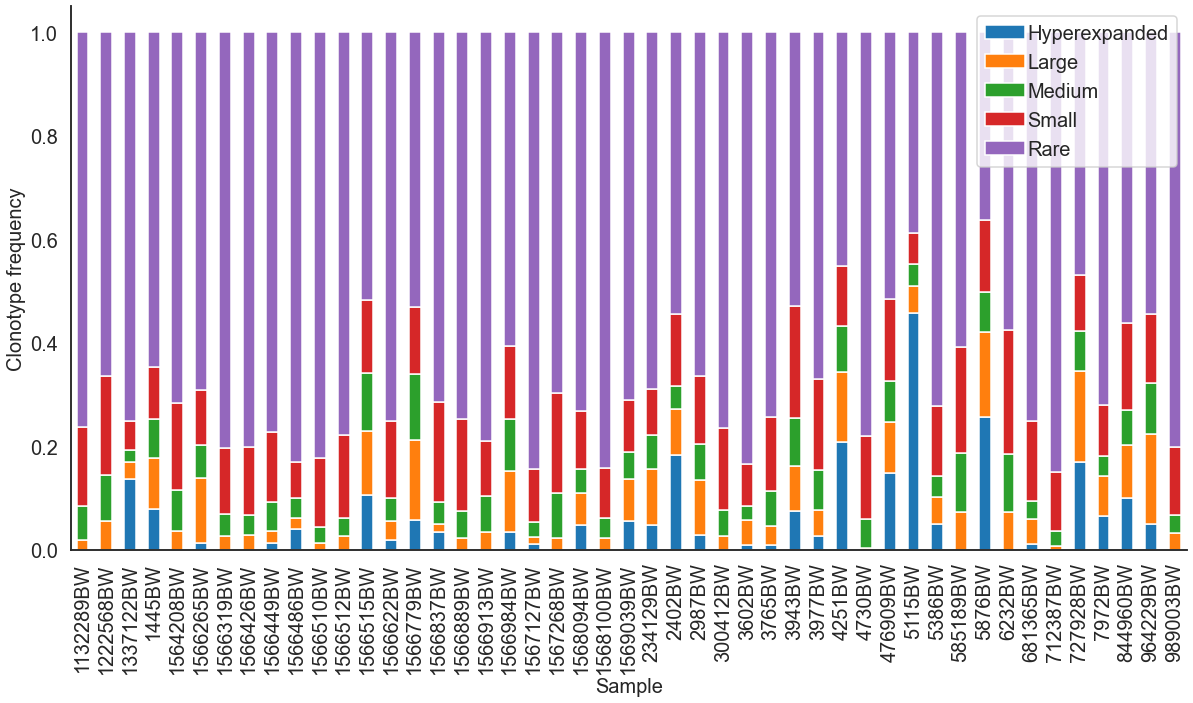

In [5]:
sns.set_style("white") 
sns.set_context("talk")

label_order = ['Hyperexpanded', 'Large', 'Medium', 'Small', 'Rare']

ax = df_relative_abundance.groupby(['sample','clonotype_group'])['freq'].sum().unstack()[label_order].plot(kind='bar', stacked=True)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:], labels[0:], loc='upper right', bbox_to_anchor=(1, 1), handletextpad=0.1, prop={'size': 20})

ax.set_xlabel('Sample',fontsize=20)
ax.set_ylabel('Clonotype frequency',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20,10)
sns.despine()

plt.savefig("../figures/supplementary/figureS3a.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS3a.png",bbox_inches="tight")

plt.show()

Relative abundance in top clonotypes

In [6]:
# Define groups based on clone counts 
def reads_group_top (row):
    if row['#count'] > 1 and row['#count'] <= 10:
        return '1-10'
    if row['#count'] >= 11 and row['#count'] <= 100:
        return '11-100'
    if row['#count'] >= 101 and row['#count'] <= 1000:
        return '101-1000'
    if row['#count'] >= 1001 and row['#count'] <= 5000:
        return '1001-5000'

# Get the top 100 clonotypes in each sample
df_top=df.sort_values(['sample', 'freq'], axis=0).groupby('sample').tail(100)

# Apply the function to the dataframe
df_top['reads_group'] = df_top.apply (lambda row: reads_group_top(row),axis=1)

# Show the result
df_top_result = df_top[['sample','hospitalized','reads_group']]
df_top_result

,sample,hospitalized,reads_group
13483113,1132289BW,False,101-1000
13483114,1132289BW,False,101-1000
13483112,1132289BW,False,101-1000
13483111,1132289BW,False,101-1000
13483110,1132289BW,False,101-1000
...,...,...,...
437916,989003BW,True,1001-5000
437915,989003BW,True,1001-5000
437914,989003BW,True,1001-5000
437913,989003BW,True,1001-5000


## FigureS3b

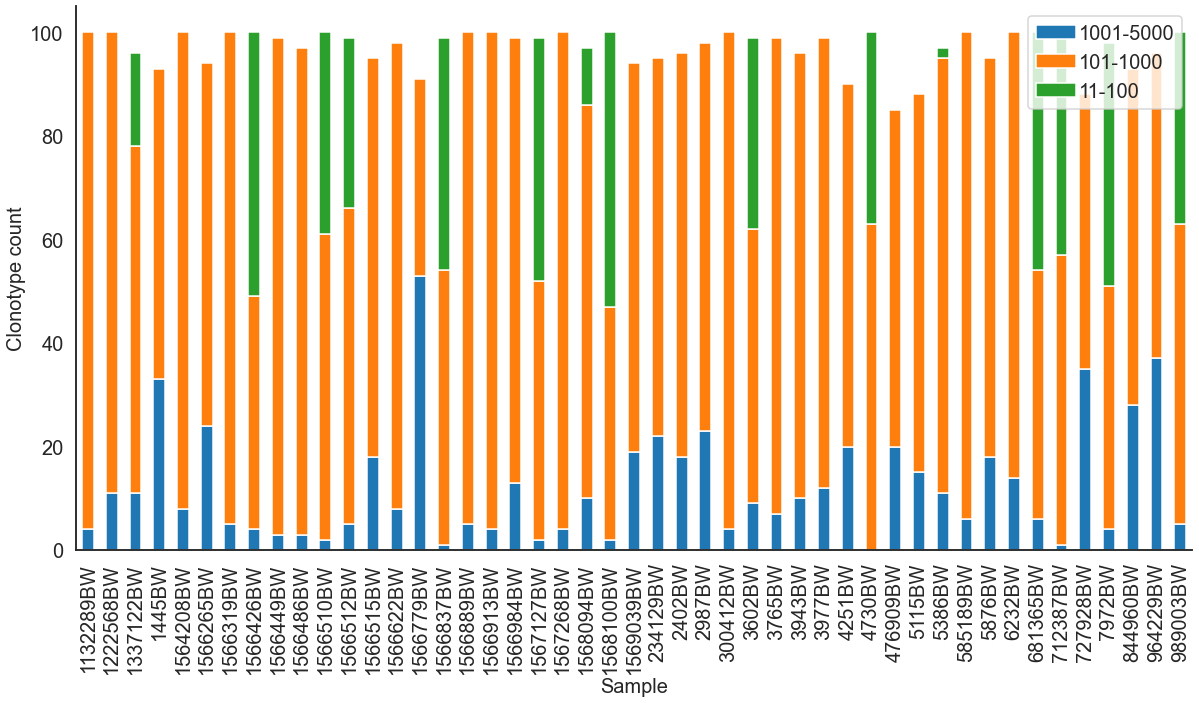

In [7]:
sns.set_style("white") 
sns.set_context("talk")

label_order = ['Hyperexpanded', 'Large', 'Medium', 'Small', 'Rare']

ax = df_top.groupby(['sample', 'reads_group'])['#count'].count().unstack().plot(kind='bar', stacked=True)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:], labels[0:], loc='upper right', bbox_to_anchor=(1, 1), handletextpad=0.1, prop={'size': 20})

ax.set_xlabel('Sample',fontsize=20)
ax.set_ylabel('Clonotype count',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20,10)
sns.despine()

plt.savefig("../figures/supplementary/figureS3b.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS3b.png",bbox_inches="tight")

plt.show()

Relative abundance in rare clonotypes

In [8]:
# Define groups based on clone counts 
def reads_group_rare (row):
    if row['#count'] == 1 :
        return '1'
    if row['#count'] >= 2 and row['#count'] <= 3:
        return '2-3'
    if row['#count'] >= 4 and row['#count'] <= 10:
        return '4-10'
    if row['#count'] >= 11 and row['#count'] <= 30:
        return '11-30'
    if row['#count'] >= 31 and row['#count'] <= 100:
        return '31-100'  
    if row['#count'] >= 101 and row['#count'] <= 200:
        return '101-200'

# Get the rare 100 clonotypes
df_rare=df.sort_values(['sample', 'freq'], axis=0).groupby('sample').head(100)

# Apply the functions to the dataframe
df_rare['reads_group'] = df_rare.apply (lambda row: reads_group_rare(row),axis=1)

# Show the result
df_rare_result = df_rare[['sample','hospitalized','reads_group']]
df_rare_result

,sample,hospitalized,reads_group
13533460,1132289BW,False,1
13533461,1132289BW,False,1
13533462,1132289BW,False,1
13533463,1132289BW,False,1
13533464,1132289BW,False,1
...,...,...,...
486385,989003BW,True,1
486386,989003BW,True,1
486387,989003BW,True,1
486388,989003BW,True,1


## Figure3c

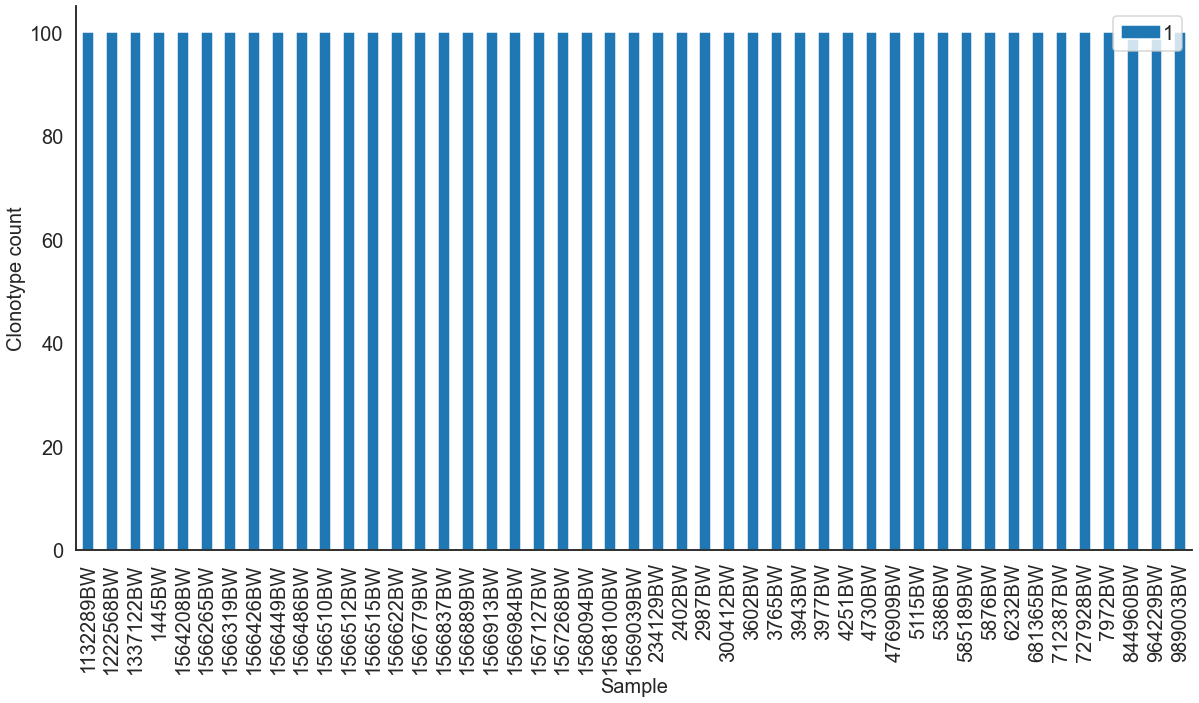

In [9]:
sns.set_style("white") 
sns.set_context("talk")

label_order = ['Hyperexpanded', 'Large', 'Medium', 'Small', 'Rare']

ax = df_rare.groupby(['sample', 'reads_group'])['#count'].count().unstack().plot(kind='bar', stacked=True)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:], labels[0:], loc='upper right', bbox_to_anchor=(1, 1), handletextpad=0.1, prop={'size': 20})

ax.set_xlabel('Sample',fontsize=20)
ax.set_ylabel('Clonotype count',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.gcf().set_size_inches(20,10)
sns.despine()

plt.savefig("../figures/supplementary/figureS3c.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS3c.png",bbox_inches="tight")

plt.show()